In [1]:
import keras
from keras.models import Sequential
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
13017,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
13018,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
13019,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
13020,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
13021,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 13022/13022 [01:26<00:00, 151.19it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(13022, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
5504,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5505,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5506,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5507,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5508,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 5509/5509 [00:41<00:00, 134.31it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(5509, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(train.nunique())
print(val.nunique())

image    13022
class       51
dtype: int64
image    5509
class      51
dtype: int64


In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(13022, 51)
(5509, 51)


In [10]:
base_model = DenseNet121(include_top=False, weights='imagenet')

In [11]:
print(base_model.output_shape)

(None, None, None, 1024)


In [12]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv3_block4_1_conv (Conv2D)    (None, None, None, 1 28672       conv3_block4_0_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_bn (BatchNormali (None, None, None, 1 512         conv3_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 3 36864       conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_concat (Concatenat (None, None, None, 2 0           conv3_block3_concat[0][0]        
                                                                 conv3_block4_2_conv[0][0]        
__________

conv4_block2_2_conv (Conv2D)    (None, None, None, 3 36864       conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_concat (Concatenat (None, None, None, 3 0           conv4_block1_concat[0][0]        
                                                                 conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_0_bn (BatchNormali (None, None, None, 3 1280        conv4_block2_concat[0][0]        
__________________________________________________________________________________________________
conv4_block3_0_relu (Activation (None, None, None, 3 0           conv4_block3_0_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, None, None, 1 40960       conv4_block3_0_relu[0][0]        
__________

__________________________________________________________________________________________________
conv4_block13_2_conv (Conv2D)   (None, None, None, 3 36864       conv4_block13_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block13_concat (Concatena (None, None, None, 6 0           conv4_block12_concat[0][0]       
                                                                 conv4_block13_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_bn (BatchNormal (None, None, None, 6 2688        conv4_block13_concat[0][0]       
__________________________________________________________________________________________________
conv4_block14_0_relu (Activatio (None, None, None, 6 0           conv4_block14_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_bloc

conv4_block24_1_relu (Activatio (None, None, None, 1 0           conv4_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block24_2_conv (Conv2D)   (None, None, None, 3 36864       conv4_block24_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block24_concat (Concatena (None, None, None, 1 0           conv4_block23_concat[0][0]       
                                                                 conv4_block24_2_conv[0][0]       
__________________________________________________________________________________________________
pool4_bn (BatchNormalization)   (None, None, None, 1 4096        conv4_block24_concat[0][0]       
__________________________________________________________________________________________________
pool4_relu (Activation)         (None, None, None, 1 0           pool4_bn[0][0]                   
__________

__________________________________________________________________________________________________
conv5_block11_0_bn (BatchNormal (None, None, None, 8 3328        conv5_block10_concat[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_relu (Activatio (None, None, None, 8 0           conv5_block11_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block11_1_conv (Conv2D)   (None, None, None, 1 106496      conv5_block11_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block11_1_bn (BatchNormal (None, None, None, 1 512         conv5_block11_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block11_1_relu (Activatio (None, None, None, 1 0           conv5_block11_1_bn[0][0]         
__________

In [13]:
base_model.get_config()

{'name': 'densenet121',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'zero_padding2d_1',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'zero_padding2d_1',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1/conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1/conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': False,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform

In [15]:
t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2-t1)

2020-03-21 20:22:51.627274
(13022, 7, 7, 1024)
2020-03-21 22:10:49.117849


In [16]:
t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4-t3)

2020-03-21 22:10:49.152777
(5509, 7, 7, 1024)
2020-03-21 22:47:23.819955


In [17]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(13022, 7*7*1024)
X_test = X_test.reshape(5509, 7*7*1024)

In [18]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [19]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/DenseNet121_X_train.pkl') 
joblib.dump(X_test, '../Pickle/DenseNet121_X_test.pkl')

['../Pickle/DenseNet121_X_test.pkl']

In [20]:
# Load the model from the file 
X_train = joblib.load('../Pickle/DenseNet121_X_train.pkl') 
X_test = joblib.load('../Pickle/DenseNet121_X_test.pkl') 

In [21]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13022, 50176)
(5509, 50176)
(13022, 51)
(5509, 51)


In [22]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(50176,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [23]:
model.output_shape

(None, 51)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [25]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 50176),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [26]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightDenseNet121.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [27]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [28]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-03-21 22:48:05.355562
Train on 13022 samples, validate on 5509 samples
Epoch 1/100
13022/13022 [==============================] - ETA: 7:40 - loss: 3.9353 - accuracy: 0.03 - ETA: 4:44 - loss: 3.9533 - accuracy: 0.03 - ETA: 3:42 - loss: 3.9665 - accuracy: 0.03 - ETA: 3:11 - loss: 3.9831 - accuracy: 0.03 - ETA: 2:52 - loss: 4.0019 - accuracy: 0.03 - ETA: 2:39 - loss: 4.0050 - accuracy: 0.03 - ETA: 2:28 - loss: 4.0045 - accuracy: 0.03 - ETA: 2:21 - loss: 4.0045 - accuracy: 0.03 - ETA: 2:15 - loss: 3.9978 - accuracy: 0.03 - ETA: 2:09 - loss: 3.9993 - accuracy: 0.03 - ETA: 2:05 - loss: 3.9966 - accuracy: 0.03 - ETA: 2:01 - loss: 3.9918 - accuracy: 0.03 - ETA: 1:59 - loss: 3.9837 - accuracy: 0.03 - ETA: 1:55 - loss: 3.9798 - accuracy: 0.03 - ETA: 1:52 - loss: 3.9764 - accuracy: 0.03 - ETA: 1:49 - loss: 3.9737 - accuracy: 0.03 - ETA: 1:46 - loss: 3.9690 - accuracy: 0.03 - ETA: 1:44 - loss: 3.9629 - accuracy: 0.03 - ETA: 1:42 - loss: 3.9624 - accuracy: 0.03 - ETA: 1:39 - loss: 3.9622 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 2.8659 - accuracy: 0.24 - ETA: 1:40 - loss: 2.9646 - accuracy: 0.20 - ETA: 1:41 - loss: 2.9548 - accuracy: 0.21 - ETA: 1:41 - loss: 2.9587 - accuracy: 0.21 - ETA: 1:40 - loss: 2.9644 - accuracy: 0.22 - ETA: 1:39 - loss: 2.9573 - accuracy: 0.21 - ETA: 1:38 - loss: 2.9482 - accuracy: 0.21 - ETA: 1:36 - loss: 2.9483 - accuracy: 0.21 - ETA: 1:35 - loss: 2.9389 - accuracy: 0.21 - ETA: 1:34 - loss: 2.9317 - accuracy: 0.22 - ETA: 1:32 - loss: 2.9135 - accuracy: 0.22 - ETA: 1:31 - loss: 2.9221 - accuracy: 0.22 - ETA: 1:29 - loss: 2.9260 - accuracy: 0.22 - ETA: 1:28 - loss: 2.9307 - accuracy: 0.22 - ETA: 1:27 - loss: 2.9378 - accuracy: 0.22 - ETA: 1:26 - loss: 2.9382 - accuracy: 0.22 - ETA: 1:25 - loss: 2.9320 - accuracy: 0.22 - ETA: 1:24 - loss: 2.9224 - accuracy: 0.23 - ETA: 1:23 - loss: 2.9195 - accuracy: 0.23 - ETA: 1:22 - loss: 2.9150 - accuracy: 0.23 - ETA: 1:21 - loss: 2.8959 - accuracy: 0.23 - ETA: 1:20 - loss: 2.8913 - ac

13022/13022 [==============================] - ETA: 1:44 - loss: 2.2960 - accuracy: 0.35 - ETA: 1:42 - loss: 2.1642 - accuracy: 0.38 - ETA: 1:39 - loss: 2.1172 - accuracy: 0.39 - ETA: 1:37 - loss: 2.1097 - accuracy: 0.41 - ETA: 1:36 - loss: 2.0945 - accuracy: 0.41 - ETA: 1:35 - loss: 2.0752 - accuracy: 0.42 - ETA: 1:33 - loss: 2.0562 - accuracy: 0.42 - ETA: 1:33 - loss: 2.0660 - accuracy: 0.42 - ETA: 1:32 - loss: 2.0650 - accuracy: 0.42 - ETA: 1:31 - loss: 2.0626 - accuracy: 0.42 - ETA: 1:30 - loss: 2.0745 - accuracy: 0.42 - ETA: 1:29 - loss: 2.0526 - accuracy: 0.43 - ETA: 1:28 - loss: 2.0580 - accuracy: 0.42 - ETA: 1:27 - loss: 2.0574 - accuracy: 0.43 - ETA: 1:26 - loss: 2.0563 - accuracy: 0.43 - ETA: 1:25 - loss: 2.0529 - accuracy: 0.43 - ETA: 1:23 - loss: 2.0597 - accuracy: 0.43 - ETA: 1:22 - loss: 2.0534 - accuracy: 0.43 - ETA: 1:22 - loss: 2.0618 - accuracy: 0.43 - ETA: 1:20 - loss: 2.0522 - accuracy: 0.43 - ETA: 1:19 - loss: 2.0589 - accuracy: 0.43 - ETA: 1:19 - loss: 2.0688 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 1.7738 - accuracy: 0.46 - ETA: 1:39 - loss: 1.7565 - accuracy: 0.46 - ETA: 1:38 - loss: 1.6933 - accuracy: 0.47 - ETA: 1:37 - loss: 1.6854 - accuracy: 0.48 - ETA: 1:35 - loss: 1.6507 - accuracy: 0.50 - ETA: 1:34 - loss: 1.6368 - accuracy: 0.51 - ETA: 1:32 - loss: 1.6352 - accuracy: 0.51 - ETA: 1:31 - loss: 1.6527 - accuracy: 0.51 - ETA: 1:30 - loss: 1.6367 - accuracy: 0.52 - ETA: 1:30 - loss: 1.6307 - accuracy: 0.52 - ETA: 1:29 - loss: 1.6453 - accuracy: 0.52 - ETA: 1:28 - loss: 1.6319 - accuracy: 0.52 - ETA: 1:27 - loss: 1.6307 - accuracy: 0.52 - ETA: 1:25 - loss: 1.6097 - accuracy: 0.52 - ETA: 1:24 - loss: 1.6092 - accuracy: 0.52 - ETA: 1:23 - loss: 1.6047 - accuracy: 0.52 - ETA: 1:22 - loss: 1.5949 - accuracy: 0.53 - ETA: 1:21 - loss: 1.5981 - accuracy: 0.53 - ETA: 1:20 - loss: 1.6015 - accuracy: 0.53 - ETA: 1:19 - loss: 1.5935 - accuracy: 0.53 - ETA: 1:18 - loss: 1.5927 - accuracy: 0.53 - ETA: 1:17 - loss: 1.5851 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 1.3400 - accuracy: 0.60 - ETA: 1:33 - loss: 1.4025 - accuracy: 0.54 - ETA: 1:32 - loss: 1.3638 - accuracy: 0.56 - ETA: 1:33 - loss: 1.3351 - accuracy: 0.57 - ETA: 1:30 - loss: 1.2946 - accuracy: 0.58 - ETA: 1:29 - loss: 1.2772 - accuracy: 0.59 - ETA: 1:29 - loss: 1.2702 - accuracy: 0.59 - ETA: 1:28 - loss: 1.2946 - accuracy: 0.58 - ETA: 1:27 - loss: 1.2884 - accuracy: 0.59 - ETA: 1:27 - loss: 1.2971 - accuracy: 0.59 - ETA: 1:26 - loss: 1.3021 - accuracy: 0.59 - ETA: 1:25 - loss: 1.2866 - accuracy: 0.60 - ETA: 1:24 - loss: 1.2815 - accuracy: 0.60 - ETA: 1:23 - loss: 1.2872 - accuracy: 0.60 - ETA: 1:22 - loss: 1.2923 - accuracy: 0.60 - ETA: 1:22 - loss: 1.2903 - accuracy: 0.60 - ETA: 1:22 - loss: 1.2967 - accuracy: 0.60 - ETA: 1:21 - loss: 1.2878 - accuracy: 0.60 - ETA: 1:20 - loss: 1.2914 - accuracy: 0.60 - ETA: 1:19 - loss: 1.2957 - accuracy: 0.60 - ETA: 1:19 - loss: 1.2878 - accuracy: 0.60 - ETA: 1:18 - loss: 1.2959 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 1.3626 - accuracy: 0.59 - ETA: 1:35 - loss: 1.2126 - accuracy: 0.60 - ETA: 1:37 - loss: 1.1603 - accuracy: 0.62 - ETA: 1:34 - loss: 1.1214 - accuracy: 0.63 - ETA: 1:33 - loss: 1.0934 - accuracy: 0.64 - ETA: 1:32 - loss: 1.0964 - accuracy: 0.65 - ETA: 1:32 - loss: 1.1199 - accuracy: 0.65 - ETA: 1:31 - loss: 1.1377 - accuracy: 0.65 - ETA: 1:30 - loss: 1.1454 - accuracy: 0.65 - ETA: 1:29 - loss: 1.1285 - accuracy: 0.66 - ETA: 1:28 - loss: 1.1178 - accuracy: 0.66 - ETA: 1:28 - loss: 1.1351 - accuracy: 0.65 - ETA: 1:27 - loss: 1.1373 - accuracy: 0.65 - ETA: 1:26 - loss: 1.1378 - accuracy: 0.65 - ETA: 1:25 - loss: 1.1455 - accuracy: 0.65 - ETA: 1:24 - loss: 1.1383 - accuracy: 0.65 - ETA: 1:23 - loss: 1.1317 - accuracy: 0.65 - ETA: 1:22 - loss: 1.1321 - accuracy: 0.65 - ETA: 1:21 - loss: 1.1329 - accuracy: 0.65 - ETA: 1:20 - loss: 1.1449 - accuracy: 0.64 - ETA: 1:19 - loss: 1.1365 - accuracy: 0.65 - ETA: 1:18 - loss: 1.1342 - ac

13022/13022 [==============================] - ETA: 1:44 - loss: 1.2486 - accuracy: 0.64 - ETA: 1:43 - loss: 1.2183 - accuracy: 0.65 - ETA: 1:42 - loss: 1.1680 - accuracy: 0.64 - ETA: 1:39 - loss: 1.1518 - accuracy: 0.66 - ETA: 1:39 - loss: 1.1852 - accuracy: 0.65 - ETA: 1:38 - loss: 1.1608 - accuracy: 0.66 - ETA: 1:37 - loss: 1.1235 - accuracy: 0.67 - ETA: 1:36 - loss: 1.1362 - accuracy: 0.66 - ETA: 1:35 - loss: 1.1070 - accuracy: 0.68 - ETA: 1:35 - loss: 1.0923 - accuracy: 0.68 - ETA: 1:34 - loss: 1.0859 - accuracy: 0.68 - ETA: 1:33 - loss: 1.1056 - accuracy: 0.67 - ETA: 1:32 - loss: 1.0993 - accuracy: 0.67 - ETA: 1:31 - loss: 1.0832 - accuracy: 0.67 - ETA: 1:30 - loss: 1.0697 - accuracy: 0.67 - ETA: 1:29 - loss: 1.0616 - accuracy: 0.67 - ETA: 1:27 - loss: 1.0647 - accuracy: 0.67 - ETA: 1:26 - loss: 1.0615 - accuracy: 0.67 - ETA: 1:25 - loss: 1.0591 - accuracy: 0.67 - ETA: 1:24 - loss: 1.0647 - accuracy: 0.67 - ETA: 1:23 - loss: 1.0597 - accuracy: 0.67 - ETA: 1:22 - loss: 1.0556 - ac

13022/13022 [==============================] - ETA: 1:45 - loss: 1.0926 - accuracy: 0.66 - ETA: 1:40 - loss: 1.0795 - accuracy: 0.67 - ETA: 1:36 - loss: 0.9867 - accuracy: 0.67 - ETA: 1:36 - loss: 1.0446 - accuracy: 0.66 - ETA: 1:34 - loss: 1.0610 - accuracy: 0.66 - ETA: 1:32 - loss: 1.0138 - accuracy: 0.67 - ETA: 1:31 - loss: 1.0339 - accuracy: 0.67 - ETA: 1:29 - loss: 1.0145 - accuracy: 0.67 - ETA: 1:28 - loss: 1.0117 - accuracy: 0.68 - ETA: 1:27 - loss: 1.0090 - accuracy: 0.68 - ETA: 1:25 - loss: 0.9949 - accuracy: 0.68 - ETA: 1:25 - loss: 0.9840 - accuracy: 0.68 - ETA: 1:24 - loss: 0.9884 - accuracy: 0.68 - ETA: 1:23 - loss: 1.0030 - accuracy: 0.68 - ETA: 1:22 - loss: 1.0010 - accuracy: 0.68 - ETA: 1:21 - loss: 1.0124 - accuracy: 0.67 - ETA: 1:19 - loss: 1.0025 - accuracy: 0.67 - ETA: 1:18 - loss: 1.0188 - accuracy: 0.67 - ETA: 1:17 - loss: 1.0149 - accuracy: 0.67 - ETA: 1:16 - loss: 1.0080 - accuracy: 0.67 - ETA: 1:15 - loss: 1.0084 - accuracy: 0.67 - ETA: 1:14 - loss: 1.0052 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 0.7762 - accuracy: 0.75 - ETA: 1:36 - loss: 0.7974 - accuracy: 0.75 - ETA: 1:36 - loss: 0.8211 - accuracy: 0.73 - ETA: 1:37 - loss: 0.8108 - accuracy: 0.73 - ETA: 1:38 - loss: 0.8127 - accuracy: 0.73 - ETA: 1:38 - loss: 0.8089 - accuracy: 0.73 - ETA: 1:37 - loss: 0.8113 - accuracy: 0.73 - ETA: 1:36 - loss: 0.8178 - accuracy: 0.73 - ETA: 1:35 - loss: 0.8039 - accuracy: 0.74 - ETA: 1:34 - loss: 0.7912 - accuracy: 0.74 - ETA: 1:34 - loss: 0.8148 - accuracy: 0.74 - ETA: 1:32 - loss: 0.8085 - accuracy: 0.74 - ETA: 1:32 - loss: 0.8204 - accuracy: 0.73 - ETA: 1:31 - loss: 0.8226 - accuracy: 0.73 - ETA: 1:30 - loss: 0.8350 - accuracy: 0.72 - ETA: 1:29 - loss: 0.8331 - accuracy: 0.72 - ETA: 1:27 - loss: 0.8425 - accuracy: 0.72 - ETA: 1:26 - loss: 0.8498 - accuracy: 0.72 - ETA: 1:25 - loss: 0.8415 - accuracy: 0.72 - ETA: 1:24 - loss: 0.8441 - accuracy: 0.72 - ETA: 1:23 - loss: 0.8471 - accuracy: 0.72 - ETA: 1:22 - loss: 0.8508 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 0.8635 - accuracy: 0.72 - ETA: 1:33 - loss: 0.8155 - accuracy: 0.74 - ETA: 1:30 - loss: 0.8196 - accuracy: 0.74 - ETA: 1:29 - loss: 0.8219 - accuracy: 0.74 - ETA: 1:28 - loss: 0.8248 - accuracy: 0.73 - ETA: 1:28 - loss: 0.8428 - accuracy: 0.73 - ETA: 1:26 - loss: 0.8306 - accuracy: 0.74 - ETA: 1:25 - loss: 0.7876 - accuracy: 0.75 - ETA: 1:24 - loss: 0.8004 - accuracy: 0.74 - ETA: 1:23 - loss: 0.7935 - accuracy: 0.74 - ETA: 1:22 - loss: 0.7821 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7717 - accuracy: 0.75 - ETA: 1:20 - loss: 0.7848 - accuracy: 0.74 - ETA: 1:18 - loss: 0.7957 - accuracy: 0.74 - ETA: 1:18 - loss: 0.8032 - accuracy: 0.74 - ETA: 1:16 - loss: 0.8051 - accuracy: 0.74 - ETA: 1:15 - loss: 0.8044 - accuracy: 0.74 - ETA: 1:15 - loss: 0.8025 - accuracy: 0.74 - ETA: 1:14 - loss: 0.8126 - accuracy: 0.73 - ETA: 1:13 - loss: 0.8083 - accuracy: 0.74 - ETA: 1:12 - loss: 0.8159 - accuracy: 0.74 - ETA: 1:11 - loss: 0.8095 - ac

13022/13022 [==============================] - ETA: 1:40 - loss: 0.6349 - accuracy: 0.80 - ETA: 1:36 - loss: 0.7945 - accuracy: 0.75 - ETA: 1:35 - loss: 0.7945 - accuracy: 0.74 - ETA: 1:35 - loss: 0.7723 - accuracy: 0.75 - ETA: 1:34 - loss: 0.7744 - accuracy: 0.75 - ETA: 1:34 - loss: 0.7961 - accuracy: 0.75 - ETA: 1:32 - loss: 0.8100 - accuracy: 0.75 - ETA: 1:32 - loss: 0.7676 - accuracy: 0.76 - ETA: 1:31 - loss: 0.7876 - accuracy: 0.75 - ETA: 1:31 - loss: 0.7671 - accuracy: 0.76 - ETA: 1:30 - loss: 0.7573 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7610 - accuracy: 0.76 - ETA: 1:28 - loss: 0.7639 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7650 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7672 - accuracy: 0.76 - ETA: 1:25 - loss: 0.7626 - accuracy: 0.76 - ETA: 1:24 - loss: 0.7637 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7702 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7731 - accuracy: 0.75 - ETA: 1:21 - loss: 0.7642 - accuracy: 0.76 - ETA: 1:21 - loss: 0.7665 - accuracy: 0.76 - ETA: 1:20 - loss: 0.7790 - ac

13022/13022 [==============================] - ETA: 1:52 - loss: 0.9348 - accuracy: 0.71 - ETA: 1:45 - loss: 0.7774 - accuracy: 0.76 - ETA: 1:42 - loss: 0.6975 - accuracy: 0.77 - ETA: 1:39 - loss: 0.7136 - accuracy: 0.76 - ETA: 1:37 - loss: 0.7122 - accuracy: 0.77 - ETA: 1:36 - loss: 0.7515 - accuracy: 0.76 - ETA: 1:34 - loss: 0.7598 - accuracy: 0.76 - ETA: 1:33 - loss: 0.7423 - accuracy: 0.76 - ETA: 1:32 - loss: 0.7480 - accuracy: 0.76 - ETA: 1:31 - loss: 0.7419 - accuracy: 0.76 - ETA: 1:30 - loss: 0.7590 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7613 - accuracy: 0.76 - ETA: 1:29 - loss: 0.7611 - accuracy: 0.76 - ETA: 1:28 - loss: 0.7590 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7490 - accuracy: 0.76 - ETA: 1:27 - loss: 0.7511 - accuracy: 0.76 - ETA: 1:26 - loss: 0.7472 - accuracy: 0.76 - ETA: 1:25 - loss: 0.7454 - accuracy: 0.77 - ETA: 1:24 - loss: 0.7464 - accuracy: 0.76 - ETA: 1:23 - loss: 0.7417 - accuracy: 0.76 - ETA: 1:22 - loss: 0.7549 - accuracy: 0.76 - ETA: 1:21 - loss: 0.7494 - ac

13022/13022 [==============================] - ETA: 1:52 - loss: 0.7248 - accuracy: 0.78 - ETA: 1:49 - loss: 0.6987 - accuracy: 0.80 - ETA: 1:44 - loss: 0.6875 - accuracy: 0.79 - ETA: 1:41 - loss: 0.6713 - accuracy: 0.79 - ETA: 1:38 - loss: 0.6658 - accuracy: 0.79 - ETA: 1:36 - loss: 0.6926 - accuracy: 0.78 - ETA: 1:34 - loss: 0.6769 - accuracy: 0.79 - ETA: 1:33 - loss: 0.6965 - accuracy: 0.78 - ETA: 1:31 - loss: 0.7077 - accuracy: 0.78 - ETA: 1:30 - loss: 0.6958 - accuracy: 0.78 - ETA: 1:29 - loss: 0.6938 - accuracy: 0.78 - ETA: 1:28 - loss: 0.6834 - accuracy: 0.78 - ETA: 1:27 - loss: 0.6839 - accuracy: 0.78 - ETA: 1:26 - loss: 0.6831 - accuracy: 0.78 - ETA: 1:25 - loss: 0.6697 - accuracy: 0.78 - ETA: 1:24 - loss: 0.6802 - accuracy: 0.77 - ETA: 1:24 - loss: 0.6881 - accuracy: 0.77 - ETA: 1:23 - loss: 0.6830 - accuracy: 0.77 - ETA: 1:23 - loss: 0.6902 - accuracy: 0.77 - ETA: 1:22 - loss: 0.6826 - accuracy: 0.78 - ETA: 1:21 - loss: 0.6861 - accuracy: 0.78 - ETA: 1:19 - loss: 0.6863 - ac

13022/13022 [==============================] - ETA: 1:44 - loss: 0.5280 - accuracy: 0.83 - ETA: 1:41 - loss: 0.5849 - accuracy: 0.83 - ETA: 1:37 - loss: 0.5584 - accuracy: 0.83 - ETA: 1:35 - loss: 0.5400 - accuracy: 0.83 - ETA: 1:33 - loss: 0.5531 - accuracy: 0.82 - ETA: 1:32 - loss: 0.6034 - accuracy: 0.80 - ETA: 1:31 - loss: 0.6059 - accuracy: 0.80 - ETA: 1:29 - loss: 0.6119 - accuracy: 0.80 - ETA: 1:28 - loss: 0.6191 - accuracy: 0.80 - ETA: 1:27 - loss: 0.6216 - accuracy: 0.80 - ETA: 1:26 - loss: 0.6203 - accuracy: 0.80 - ETA: 1:24 - loss: 0.6241 - accuracy: 0.79 - ETA: 1:23 - loss: 0.6250 - accuracy: 0.79 - ETA: 1:22 - loss: 0.6269 - accuracy: 0.79 - ETA: 1:21 - loss: 0.6393 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6331 - accuracy: 0.79 - ETA: 1:19 - loss: 0.6347 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6374 - accuracy: 0.79 - ETA: 1:20 - loss: 0.6411 - accuracy: 0.79 - ETA: 1:19 - loss: 0.6428 - accuracy: 0.79 - ETA: 1:18 - loss: 0.6417 - accuracy: 0.79 - ETA: 1:17 - loss: 0.6362 - ac

13022/13022 [==============================] - ETA: 1:11 - loss: 0.4785 - accuracy: 0.79 - ETA: 1:09 - loss: 0.5833 - accuracy: 0.78 - ETA: 1:07 - loss: 0.5794 - accuracy: 0.79 - ETA: 1:06 - loss: 0.6068 - accuracy: 0.78 - ETA: 1:06 - loss: 0.6255 - accuracy: 0.78 - ETA: 1:05 - loss: 0.6144 - accuracy: 0.79 - ETA: 1:05 - loss: 0.5950 - accuracy: 0.80 - ETA: 1:05 - loss: 0.5870 - accuracy: 0.79 - ETA: 1:05 - loss: 0.5855 - accuracy: 0.80 - ETA: 1:04 - loss: 0.5821 - accuracy: 0.80 - ETA: 1:04 - loss: 0.5794 - accuracy: 0.80 - ETA: 1:03 - loss: 0.5838 - accuracy: 0.80 - ETA: 1:02 - loss: 0.6027 - accuracy: 0.79 - ETA: 1:02 - loss: 0.5969 - accuracy: 0.79 - ETA: 1:01 - loss: 0.5894 - accuracy: 0.79 - ETA: 1:01 - loss: 0.5904 - accuracy: 0.79 - ETA: 1:00 - loss: 0.5903 - accuracy: 0.80 - ETA: 59s - loss: 0.5868 - accuracy: 0.8038 - ETA: 59s - loss: 0.5934 - accuracy: 0.802 - ETA: 58s - loss: 0.6073 - accuracy: 0.800 - ETA: 57s - loss: 0.6139 - accuracy: 0.799 - ETA: 57s - loss: 0.6156 - ac

13022/13022 [==============================] - ETA: 1:17 - loss: 0.6274 - accuracy: 0.80 - ETA: 1:13 - loss: 0.5387 - accuracy: 0.82 - ETA: 1:11 - loss: 0.5521 - accuracy: 0.81 - ETA: 1:09 - loss: 0.5385 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5716 - accuracy: 0.81 - ETA: 1:07 - loss: 0.5638 - accuracy: 0.82 - ETA: 1:05 - loss: 0.5829 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5873 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5906 - accuracy: 0.81 - ETA: 1:04 - loss: 0.5886 - accuracy: 0.81 - ETA: 1:03 - loss: 0.5959 - accuracy: 0.80 - ETA: 1:02 - loss: 0.5943 - accuracy: 0.80 - ETA: 1:02 - loss: 0.5876 - accuracy: 0.80 - ETA: 1:02 - loss: 0.5871 - accuracy: 0.80 - ETA: 1:01 - loss: 0.6001 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6083 - accuracy: 0.80 - ETA: 1:00 - loss: 0.6044 - accuracy: 0.80 - ETA: 59s - loss: 0.6015 - accuracy: 0.8038 - ETA: 58s - loss: 0.5953 - accuracy: 0.808 - ETA: 57s - loss: 0.6010 - accuracy: 0.807 - ETA: 56s - loss: 0.5934 - accuracy: 0.808 - ETA: 56s - loss: 0.5941 - ac

13022/13022 [==============================] - ETA: 1:07 - loss: 0.7404 - accuracy: 0.75 - ETA: 1:05 - loss: 0.5997 - accuracy: 0.82 - ETA: 1:04 - loss: 0.6913 - accuracy: 0.79 - ETA: 1:03 - loss: 0.6638 - accuracy: 0.81 - ETA: 1:02 - loss: 0.6361 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6386 - accuracy: 0.81 - ETA: 1:00 - loss: 0.6533 - accuracy: 0.81 - ETA: 59s - loss: 0.6406 - accuracy: 0.8115 - ETA: 58s - loss: 0.6427 - accuracy: 0.804 - ETA: 57s - loss: 0.6275 - accuracy: 0.805 - ETA: 57s - loss: 0.6151 - accuracy: 0.806 - ETA: 56s - loss: 0.6287 - accuracy: 0.803 - ETA: 56s - loss: 0.6293 - accuracy: 0.804 - ETA: 55s - loss: 0.6206 - accuracy: 0.808 - ETA: 54s - loss: 0.6144 - accuracy: 0.810 - ETA: 54s - loss: 0.6067 - accuracy: 0.812 - ETA: 53s - loss: 0.6026 - accuracy: 0.814 - ETA: 52s - loss: 0.6039 - accuracy: 0.814 - ETA: 52s - loss: 0.6026 - accuracy: 0.815 - ETA: 52s - loss: 0.5966 - accuracy: 0.817 - ETA: 51s - loss: 0.6068 - accuracy: 0.814 - ETA: 51s - loss: 0.6057 - ac

13022/13022 [==============================] - ETA: 1:09 - loss: 0.5760 - accuracy: 0.81 - ETA: 1:06 - loss: 0.5389 - accuracy: 0.80 - ETA: 1:05 - loss: 0.5278 - accuracy: 0.80 - ETA: 1:04 - loss: 0.5322 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5629 - accuracy: 0.81 - ETA: 1:02 - loss: 0.5685 - accuracy: 0.82 - ETA: 1:01 - loss: 0.5733 - accuracy: 0.81 - ETA: 1:01 - loss: 0.5615 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5642 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5552 - accuracy: 0.81 - ETA: 1:00 - loss: 0.5611 - accuracy: 0.81 - ETA: 59s - loss: 0.5561 - accuracy: 0.8184 - ETA: 58s - loss: 0.5523 - accuracy: 0.819 - ETA: 57s - loss: 0.5512 - accuracy: 0.821 - ETA: 57s - loss: 0.5573 - accuracy: 0.821 - ETA: 56s - loss: 0.5466 - accuracy: 0.825 - ETA: 55s - loss: 0.5513 - accuracy: 0.823 - ETA: 54s - loss: 0.5597 - accuracy: 0.820 - ETA: 54s - loss: 0.5652 - accuracy: 0.818 - ETA: 53s - loss: 0.5744 - accuracy: 0.816 - ETA: 52s - loss: 0.5906 - accuracy: 0.812 - ETA: 52s - loss: 0.5924 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 0.5869 - accuracy: 0.82 - ETA: 1:07 - loss: 0.5852 - accuracy: 0.85 - ETA: 1:06 - loss: 0.5449 - accuracy: 0.84 - ETA: 1:04 - loss: 0.5511 - accuracy: 0.84 - ETA: 1:03 - loss: 0.5548 - accuracy: 0.84 - ETA: 1:02 - loss: 0.5374 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5394 - accuracy: 0.84 - ETA: 1:01 - loss: 0.5393 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5296 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5360 - accuracy: 0.84 - ETA: 1:00 - loss: 0.5424 - accuracy: 0.84 - ETA: 59s - loss: 0.5555 - accuracy: 0.8340 - ETA: 58s - loss: 0.5493 - accuracy: 0.835 - ETA: 58s - loss: 0.5572 - accuracy: 0.831 - ETA: 57s - loss: 0.5496 - accuracy: 0.835 - ETA: 57s - loss: 0.5500 - accuracy: 0.835 - ETA: 56s - loss: 0.5575 - accuracy: 0.835 - ETA: 55s - loss: 0.5502 - accuracy: 0.836 - ETA: 54s - loss: 0.5506 - accuracy: 0.836 - ETA: 54s - loss: 0.5563 - accuracy: 0.833 - ETA: 53s - loss: 0.5645 - accuracy: 0.832 - ETA: 52s - loss: 0.5602 - ac

13022/13022 [==============================] - ETA: 1:10 - loss: 0.4223 - accuracy: 0.84 - ETA: 1:06 - loss: 0.4602 - accuracy: 0.83 - ETA: 1:04 - loss: 0.5041 - accuracy: 0.83 - ETA: 1:03 - loss: 0.5397 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5451 - accuracy: 0.83 - ETA: 1:02 - loss: 0.5519 - accuracy: 0.83 - ETA: 1:01 - loss: 0.5487 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5478 - accuracy: 0.83 - ETA: 1:00 - loss: 0.5376 - accuracy: 0.84 - ETA: 59s - loss: 0.5364 - accuracy: 0.8391 - ETA: 58s - loss: 0.5463 - accuracy: 0.837 - ETA: 58s - loss: 0.5603 - accuracy: 0.833 - ETA: 57s - loss: 0.5521 - accuracy: 0.834 - ETA: 57s - loss: 0.5533 - accuracy: 0.832 - ETA: 56s - loss: 0.5526 - accuracy: 0.834 - ETA: 56s - loss: 0.5617 - accuracy: 0.831 - ETA: 55s - loss: 0.5564 - accuracy: 0.834 - ETA: 55s - loss: 0.5649 - accuracy: 0.832 - ETA: 54s - loss: 0.5563 - accuracy: 0.834 - ETA: 53s - loss: 0.5629 - accuracy: 0.831 - ETA: 53s - loss: 0.5760 - accuracy: 0.828 - ETA: 52s - loss: 0.5709 - ac

13022/13022 [==============================] - ETA: 1:05 - loss: 0.6323 - accuracy: 0.81 - ETA: 1:01 - loss: 0.6065 - accuracy: 0.83 - ETA: 58s - loss: 0.5598 - accuracy: 0.8438 - ETA: 56s - loss: 0.5288 - accuracy: 0.849 - ETA: 55s - loss: 0.5480 - accuracy: 0.837 - ETA: 55s - loss: 0.5515 - accuracy: 0.834 - ETA: 54s - loss: 0.5309 - accuracy: 0.833 - ETA: 53s - loss: 0.5302 - accuracy: 0.835 - ETA: 52s - loss: 0.5324 - accuracy: 0.831 - ETA: 51s - loss: 0.5318 - accuracy: 0.831 - ETA: 51s - loss: 0.5287 - accuracy: 0.833 - ETA: 50s - loss: 0.5130 - accuracy: 0.837 - ETA: 49s - loss: 0.5081 - accuracy: 0.841 - ETA: 49s - loss: 0.4981 - accuracy: 0.844 - ETA: 48s - loss: 0.4971 - accuracy: 0.841 - ETA: 48s - loss: 0.4832 - accuracy: 0.847 - ETA: 47s - loss: 0.4777 - accuracy: 0.847 - ETA: 47s - loss: 0.4732 - accuracy: 0.849 - ETA: 46s - loss: 0.4843 - accuracy: 0.847 - ETA: 46s - loss: 0.4767 - accuracy: 0.850 - ETA: 46s - loss: 0.4813 - accuracy: 0.848 - ETA: 45s - loss: 0.4802 - ac

13022/13022 [==============================] - ETA: 1:01 - loss: 0.7461 - accuracy: 0.76 - ETA: 59s - loss: 0.6475 - accuracy: 0.8008 - ETA: 56s - loss: 0.6399 - accuracy: 0.791 - ETA: 55s - loss: 0.6203 - accuracy: 0.806 - ETA: 55s - loss: 0.5902 - accuracy: 0.818 - ETA: 54s - loss: 0.5591 - accuracy: 0.829 - ETA: 53s - loss: 0.5482 - accuracy: 0.827 - ETA: 53s - loss: 0.5356 - accuracy: 0.835 - ETA: 52s - loss: 0.5225 - accuracy: 0.840 - ETA: 51s - loss: 0.5180 - accuracy: 0.842 - ETA: 51s - loss: 0.5018 - accuracy: 0.847 - ETA: 50s - loss: 0.5056 - accuracy: 0.846 - ETA: 49s - loss: 0.5110 - accuracy: 0.848 - ETA: 49s - loss: 0.5165 - accuracy: 0.844 - ETA: 49s - loss: 0.5045 - accuracy: 0.847 - ETA: 49s - loss: 0.4995 - accuracy: 0.851 - ETA: 48s - loss: 0.4934 - accuracy: 0.852 - ETA: 47s - loss: 0.5013 - accuracy: 0.852 - ETA: 47s - loss: 0.5072 - accuracy: 0.850 - ETA: 46s - loss: 0.5067 - accuracy: 0.849 - ETA: 45s - loss: 0.5083 - accuracy: 0.849 - ETA: 45s - loss: 0.5080 - ac

13022/13022 [==============================] - ETA: 1:01 - loss: 0.5547 - accuracy: 0.84 - ETA: 58s - loss: 0.4996 - accuracy: 0.8672 - ETA: 56s - loss: 0.4296 - accuracy: 0.875 - ETA: 55s - loss: 0.4414 - accuracy: 0.871 - ETA: 56s - loss: 0.4578 - accuracy: 0.864 - ETA: 56s - loss: 0.4465 - accuracy: 0.869 - ETA: 56s - loss: 0.4383 - accuracy: 0.871 - ETA: 55s - loss: 0.4448 - accuracy: 0.869 - ETA: 55s - loss: 0.4438 - accuracy: 0.866 - ETA: 55s - loss: 0.4381 - accuracy: 0.868 - ETA: 54s - loss: 0.4403 - accuracy: 0.863 - ETA: 53s - loss: 0.4354 - accuracy: 0.864 - ETA: 52s - loss: 0.4258 - accuracy: 0.865 - ETA: 51s - loss: 0.4424 - accuracy: 0.861 - ETA: 51s - loss: 0.4373 - accuracy: 0.861 - ETA: 50s - loss: 0.4343 - accuracy: 0.860 - ETA: 49s - loss: 0.4341 - accuracy: 0.860 - ETA: 48s - loss: 0.4352 - accuracy: 0.861 - ETA: 48s - loss: 0.4400 - accuracy: 0.859 - ETA: 47s - loss: 0.4514 - accuracy: 0.859 - ETA: 47s - loss: 0.4472 - accuracy: 0.859 - ETA: 46s - loss: 0.4502 - ac

13022/13022 [==============================] - ETA: 1:01 - loss: 0.4106 - accuracy: 0.86 - ETA: 58s - loss: 0.3783 - accuracy: 0.8906 - ETA: 58s - loss: 0.3815 - accuracy: 0.898 - ETA: 56s - loss: 0.4293 - accuracy: 0.892 - ETA: 55s - loss: 0.4351 - accuracy: 0.890 - ETA: 55s - loss: 0.4290 - accuracy: 0.890 - ETA: 55s - loss: 0.4191 - accuracy: 0.889 - ETA: 54s - loss: 0.4452 - accuracy: 0.875 - ETA: 53s - loss: 0.4439 - accuracy: 0.874 - ETA: 53s - loss: 0.4351 - accuracy: 0.873 - ETA: 52s - loss: 0.4237 - accuracy: 0.877 - ETA: 51s - loss: 0.4233 - accuracy: 0.877 - ETA: 51s - loss: 0.4304 - accuracy: 0.872 - ETA: 50s - loss: 0.4357 - accuracy: 0.872 - ETA: 49s - loss: 0.4368 - accuracy: 0.872 - ETA: 49s - loss: 0.4379 - accuracy: 0.872 - ETA: 48s - loss: 0.4343 - accuracy: 0.872 - ETA: 47s - loss: 0.4422 - accuracy: 0.870 - ETA: 47s - loss: 0.4468 - accuracy: 0.869 - ETA: 46s - loss: 0.4545 - accuracy: 0.867 - ETA: 46s - loss: 0.4555 - accuracy: 0.865 - ETA: 45s - loss: 0.4549 - ac

13022/13022 [==============================] - ETA: 1:01 - loss: 0.4102 - accuracy: 0.87 - ETA: 59s - loss: 0.3755 - accuracy: 0.8906 - ETA: 58s - loss: 0.4006 - accuracy: 0.877 - ETA: 56s - loss: 0.4011 - accuracy: 0.877 - ETA: 56s - loss: 0.4345 - accuracy: 0.868 - ETA: 54s - loss: 0.4279 - accuracy: 0.869 - ETA: 54s - loss: 0.4395 - accuracy: 0.862 - ETA: 53s - loss: 0.4398 - accuracy: 0.859 - ETA: 53s - loss: 0.4250 - accuracy: 0.862 - ETA: 52s - loss: 0.4039 - accuracy: 0.868 - ETA: 51s - loss: 0.4116 - accuracy: 0.866 - ETA: 51s - loss: 0.4090 - accuracy: 0.868 - ETA: 50s - loss: 0.4034 - accuracy: 0.869 - ETA: 50s - loss: 0.4059 - accuracy: 0.866 - ETA: 49s - loss: 0.4164 - accuracy: 0.864 - ETA: 48s - loss: 0.4142 - accuracy: 0.865 - ETA: 48s - loss: 0.4151 - accuracy: 0.865 - ETA: 47s - loss: 0.4129 - accuracy: 0.866 - ETA: 47s - loss: 0.4129 - accuracy: 0.869 - ETA: 46s - loss: 0.4143 - accuracy: 0.868 - ETA: 46s - loss: 0.4176 - accuracy: 0.867 - ETA: 46s - loss: 0.4244 - ac

13022/13022 [==============================] - ETA: 1:00 - loss: 0.4477 - accuracy: 0.85 - ETA: 58s - loss: 0.5169 - accuracy: 0.8281 - ETA: 56s - loss: 0.5031 - accuracy: 0.830 - ETA: 56s - loss: 0.4871 - accuracy: 0.843 - ETA: 55s - loss: 0.4414 - accuracy: 0.860 - ETA: 55s - loss: 0.4519 - accuracy: 0.864 - ETA: 54s - loss: 0.4646 - accuracy: 0.862 - ETA: 53s - loss: 0.4750 - accuracy: 0.860 - ETA: 52s - loss: 0.4637 - accuracy: 0.864 - ETA: 52s - loss: 0.4688 - accuracy: 0.864 - ETA: 51s - loss: 0.4640 - accuracy: 0.865 - ETA: 51s - loss: 0.4857 - accuracy: 0.857 - ETA: 50s - loss: 0.4819 - accuracy: 0.857 - ETA: 50s - loss: 0.4688 - accuracy: 0.860 - ETA: 50s - loss: 0.4760 - accuracy: 0.857 - ETA: 49s - loss: 0.4796 - accuracy: 0.855 - ETA: 49s - loss: 0.4697 - accuracy: 0.857 - ETA: 48s - loss: 0.4705 - accuracy: 0.857 - ETA: 47s - loss: 0.4794 - accuracy: 0.856 - ETA: 47s - loss: 0.4757 - accuracy: 0.856 - ETA: 46s - loss: 0.4707 - accuracy: 0.857 - ETA: 46s - loss: 0.4652 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.2677 - accuracy: 0.93 - ETA: 1:33 - loss: 0.2681 - accuracy: 0.91 - ETA: 1:31 - loss: 0.2852 - accuracy: 0.89 - ETA: 1:30 - loss: 0.3311 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3415 - accuracy: 0.88 - ETA: 1:27 - loss: 0.3607 - accuracy: 0.87 - ETA: 1:26 - loss: 0.3997 - accuracy: 0.86 - ETA: 1:24 - loss: 0.4041 - accuracy: 0.86 - ETA: 1:24 - loss: 0.4187 - accuracy: 0.86 - ETA: 1:23 - loss: 0.4216 - accuracy: 0.86 - ETA: 1:22 - loss: 0.4165 - accuracy: 0.86 - ETA: 1:21 - loss: 0.4055 - accuracy: 0.87 - ETA: 1:20 - loss: 0.4113 - accuracy: 0.86 - ETA: 1:19 - loss: 0.4225 - accuracy: 0.86 - ETA: 1:18 - loss: 0.4166 - accuracy: 0.86 - ETA: 1:17 - loss: 0.4150 - accuracy: 0.86 - ETA: 1:16 - loss: 0.4076 - accuracy: 0.86 - ETA: 1:15 - loss: 0.4102 - accuracy: 0.86 - ETA: 1:14 - loss: 0.4038 - accuracy: 0.87 - ETA: 1:13 - loss: 0.4049 - accuracy: 0.87 - ETA: 1:12 - loss: 0.4038 - accuracy: 0.87 - ETA: 1:11 - loss: 0.4047 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.5255 - accuracy: 0.87 - ETA: 1:29 - loss: 0.4524 - accuracy: 0.89 - ETA: 1:28 - loss: 0.4551 - accuracy: 0.87 - ETA: 1:27 - loss: 0.4532 - accuracy: 0.87 - ETA: 1:26 - loss: 0.4749 - accuracy: 0.87 - ETA: 1:25 - loss: 0.4846 - accuracy: 0.87 - ETA: 1:24 - loss: 0.4992 - accuracy: 0.86 - ETA: 1:24 - loss: 0.4786 - accuracy: 0.86 - ETA: 1:23 - loss: 0.4802 - accuracy: 0.86 - ETA: 1:23 - loss: 0.4552 - accuracy: 0.87 - ETA: 1:22 - loss: 0.4674 - accuracy: 0.86 - ETA: 1:21 - loss: 0.4587 - accuracy: 0.87 - ETA: 1:21 - loss: 0.4540 - accuracy: 0.87 - ETA: 1:20 - loss: 0.4554 - accuracy: 0.86 - ETA: 1:19 - loss: 0.4517 - accuracy: 0.86 - ETA: 1:18 - loss: 0.4527 - accuracy: 0.86 - ETA: 1:17 - loss: 0.4526 - accuracy: 0.86 - ETA: 1:16 - loss: 0.4513 - accuracy: 0.86 - ETA: 1:15 - loss: 0.4529 - accuracy: 0.87 - ETA: 1:14 - loss: 0.4431 - accuracy: 0.87 - ETA: 1:13 - loss: 0.4442 - accuracy: 0.87 - ETA: 1:12 - loss: 0.4351 - ac

13022/13022 [==============================] - ETA: 1:27 - loss: 0.3851 - accuracy: 0.89 - ETA: 1:29 - loss: 0.4822 - accuracy: 0.86 - ETA: 1:26 - loss: 0.4371 - accuracy: 0.87 - ETA: 1:26 - loss: 0.4634 - accuracy: 0.86 - ETA: 1:27 - loss: 0.4552 - accuracy: 0.87 - ETA: 1:26 - loss: 0.4578 - accuracy: 0.87 - ETA: 1:25 - loss: 0.4260 - accuracy: 0.88 - ETA: 1:24 - loss: 0.4032 - accuracy: 0.89 - ETA: 1:24 - loss: 0.4063 - accuracy: 0.88 - ETA: 1:23 - loss: 0.4185 - accuracy: 0.88 - ETA: 1:23 - loss: 0.4078 - accuracy: 0.88 - ETA: 1:22 - loss: 0.4055 - accuracy: 0.88 - ETA: 1:21 - loss: 0.4027 - accuracy: 0.88 - ETA: 1:20 - loss: 0.3911 - accuracy: 0.89 - ETA: 1:20 - loss: 0.3963 - accuracy: 0.88 - ETA: 1:19 - loss: 0.4059 - accuracy: 0.88 - ETA: 1:18 - loss: 0.4065 - accuracy: 0.88 - ETA: 1:17 - loss: 0.4014 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3956 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3986 - accuracy: 0.88 - ETA: 1:14 - loss: 0.4002 - accuracy: 0.88 - ETA: 1:12 - loss: 0.3943 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.4052 - accuracy: 0.88 - ETA: 1:31 - loss: 0.3825 - accuracy: 0.88 - ETA: 1:31 - loss: 0.3419 - accuracy: 0.89 - ETA: 1:33 - loss: 0.3446 - accuracy: 0.89 - ETA: 1:31 - loss: 0.3504 - accuracy: 0.89 - ETA: 1:29 - loss: 0.3634 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3552 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3623 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3523 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3548 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3626 - accuracy: 0.89 - ETA: 1:21 - loss: 0.3628 - accuracy: 0.89 - ETA: 1:20 - loss: 0.3631 - accuracy: 0.89 - ETA: 1:19 - loss: 0.3641 - accuracy: 0.89 - ETA: 1:18 - loss: 0.3776 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3806 - accuracy: 0.89 - ETA: 1:16 - loss: 0.3789 - accuracy: 0.89 - ETA: 1:15 - loss: 0.3762 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3712 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3772 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3779 - accuracy: 0.89 - ETA: 1:12 - loss: 0.3770 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.3860 - accuracy: 0.87 - ETA: 1:30 - loss: 0.4580 - accuracy: 0.86 - ETA: 1:28 - loss: 0.4304 - accuracy: 0.86 - ETA: 1:27 - loss: 0.3985 - accuracy: 0.88 - ETA: 1:26 - loss: 0.3970 - accuracy: 0.88 - ETA: 1:25 - loss: 0.3834 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3729 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3795 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3892 - accuracy: 0.88 - ETA: 1:21 - loss: 0.4113 - accuracy: 0.88 - ETA: 1:20 - loss: 0.4057 - accuracy: 0.87 - ETA: 1:19 - loss: 0.4011 - accuracy: 0.88 - ETA: 1:18 - loss: 0.3991 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3863 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3875 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3858 - accuracy: 0.88 - ETA: 1:15 - loss: 0.3880 - accuracy: 0.88 - ETA: 1:14 - loss: 0.3853 - accuracy: 0.88 - ETA: 1:14 - loss: 0.3882 - accuracy: 0.88 - ETA: 1:13 - loss: 0.3926 - accuracy: 0.88 - ETA: 1:12 - loss: 0.3980 - accuracy: 0.88 - ETA: 1:11 - loss: 0.3927 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 0.3352 - accuracy: 0.92 - ETA: 1:35 - loss: 0.4505 - accuracy: 0.88 - ETA: 1:35 - loss: 0.4356 - accuracy: 0.88 - ETA: 1:34 - loss: 0.3970 - accuracy: 0.89 - ETA: 1:32 - loss: 0.3753 - accuracy: 0.89 - ETA: 1:29 - loss: 0.3667 - accuracy: 0.89 - ETA: 1:27 - loss: 0.3608 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3633 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3635 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3648 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3569 - accuracy: 0.90 - ETA: 1:22 - loss: 0.3672 - accuracy: 0.89 - ETA: 1:20 - loss: 0.3644 - accuracy: 0.89 - ETA: 1:19 - loss: 0.3606 - accuracy: 0.89 - ETA: 1:18 - loss: 0.3664 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3687 - accuracy: 0.89 - ETA: 1:16 - loss: 0.3654 - accuracy: 0.89 - ETA: 1:15 - loss: 0.3635 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3626 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3565 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3599 - accuracy: 0.89 - ETA: 1:12 - loss: 0.3561 - ac

13022/13022 [==============================] - ETA: 1:32 - loss: 0.2493 - accuracy: 0.92 - ETA: 1:30 - loss: 0.3029 - accuracy: 0.91 - ETA: 1:28 - loss: 0.3409 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3203 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3234 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3609 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3568 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3710 - accuracy: 0.88 - ETA: 1:21 - loss: 0.3723 - accuracy: 0.88 - ETA: 1:20 - loss: 0.3743 - accuracy: 0.88 - ETA: 1:19 - loss: 0.3846 - accuracy: 0.88 - ETA: 1:19 - loss: 0.3800 - accuracy: 0.88 - ETA: 1:18 - loss: 0.3884 - accuracy: 0.88 - ETA: 1:17 - loss: 0.3829 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3794 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3763 - accuracy: 0.89 - ETA: 1:15 - loss: 0.3732 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3717 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3729 - accuracy: 0.89 - ETA: 1:12 - loss: 0.3784 - accuracy: 0.88 - ETA: 1:11 - loss: 0.3739 - accuracy: 0.88 - ETA: 1:10 - loss: 0.3762 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 0.3045 - accuracy: 0.88 - ETA: 1:30 - loss: 0.2886 - accuracy: 0.91 - ETA: 1:29 - loss: 0.3407 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3323 - accuracy: 0.90 - ETA: 1:28 - loss: 0.3520 - accuracy: 0.90 - ETA: 1:26 - loss: 0.4031 - accuracy: 0.89 - ETA: 1:24 - loss: 0.4115 - accuracy: 0.88 - ETA: 1:23 - loss: 0.4186 - accuracy: 0.88 - ETA: 1:22 - loss: 0.4134 - accuracy: 0.88 - ETA: 1:21 - loss: 0.4265 - accuracy: 0.88 - ETA: 1:20 - loss: 0.4196 - accuracy: 0.88 - ETA: 1:20 - loss: 0.4100 - accuracy: 0.88 - ETA: 1:19 - loss: 0.4045 - accuracy: 0.88 - ETA: 1:19 - loss: 0.3979 - accuracy: 0.89 - ETA: 1:18 - loss: 0.3942 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3926 - accuracy: 0.88 - ETA: 1:16 - loss: 0.3850 - accuracy: 0.89 - ETA: 1:15 - loss: 0.3916 - accuracy: 0.88 - ETA: 1:14 - loss: 0.3882 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3862 - accuracy: 0.89 - ETA: 1:12 - loss: 0.3783 - accuracy: 0.89 - ETA: 1:11 - loss: 0.3793 - ac

13022/13022 [==============================] - ETA: 1:39 - loss: 0.3716 - accuracy: 0.91 - ETA: 1:35 - loss: 0.3562 - accuracy: 0.90 - ETA: 1:34 - loss: 0.3253 - accuracy: 0.91 - ETA: 1:33 - loss: 0.2941 - accuracy: 0.91 - ETA: 1:30 - loss: 0.3052 - accuracy: 0.91 - ETA: 1:28 - loss: 0.3269 - accuracy: 0.91 - ETA: 1:27 - loss: 0.3381 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3735 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3713 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3858 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3853 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3738 - accuracy: 0.89 - ETA: 1:21 - loss: 0.3639 - accuracy: 0.89 - ETA: 1:19 - loss: 0.3648 - accuracy: 0.89 - ETA: 1:18 - loss: 0.3588 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3541 - accuracy: 0.89 - ETA: 1:16 - loss: 0.3627 - accuracy: 0.89 - ETA: 1:15 - loss: 0.3582 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3509 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3507 - accuracy: 0.89 - ETA: 1:12 - loss: 0.3433 - accuracy: 0.90 - ETA: 1:11 - loss: 0.3432 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 0.6313 - accuracy: 0.82 - ETA: 1:30 - loss: 0.4538 - accuracy: 0.88 - ETA: 1:29 - loss: 0.4029 - accuracy: 0.89 - ETA: 1:27 - loss: 0.4093 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3740 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3906 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3630 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3530 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3558 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3676 - accuracy: 0.89 - ETA: 1:23 - loss: 0.3702 - accuracy: 0.89 - ETA: 1:21 - loss: 0.3606 - accuracy: 0.89 - ETA: 1:20 - loss: 0.3537 - accuracy: 0.89 - ETA: 1:19 - loss: 0.3481 - accuracy: 0.89 - ETA: 1:18 - loss: 0.3530 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3531 - accuracy: 0.89 - ETA: 1:16 - loss: 0.3534 - accuracy: 0.89 - ETA: 1:15 - loss: 0.3477 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3543 - accuracy: 0.89 - ETA: 1:13 - loss: 0.3532 - accuracy: 0.89 - ETA: 1:12 - loss: 0.3493 - accuracy: 0.89 - ETA: 1:11 - loss: 0.3575 - ac

13022/13022 [==============================] - ETA: 1:36 - loss: 0.4097 - accuracy: 0.88 - ETA: 1:32 - loss: 0.4756 - accuracy: 0.88 - ETA: 1:32 - loss: 0.4398 - accuracy: 0.89 - ETA: 1:31 - loss: 0.4044 - accuracy: 0.89 - ETA: 1:30 - loss: 0.3602 - accuracy: 0.90 - ETA: 1:29 - loss: 0.3718 - accuracy: 0.89 - ETA: 1:29 - loss: 0.3794 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3754 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3698 - accuracy: 0.89 - ETA: 1:24 - loss: 0.3851 - accuracy: 0.88 - ETA: 1:23 - loss: 0.3743 - accuracy: 0.89 - ETA: 1:22 - loss: 0.3724 - accuracy: 0.89 - ETA: 1:21 - loss: 0.3773 - accuracy: 0.89 - ETA: 1:20 - loss: 0.3656 - accuracy: 0.89 - ETA: 1:19 - loss: 0.3609 - accuracy: 0.89 - ETA: 1:18 - loss: 0.3594 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3532 - accuracy: 0.89 - ETA: 1:16 - loss: 0.3472 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3471 - accuracy: 0.89 - ETA: 1:14 - loss: 0.3472 - accuracy: 0.90 - ETA: 1:13 - loss: 0.3481 - accuracy: 0.90 - ETA: 1:12 - loss: 0.3493 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.1682 - accuracy: 0.93 - ETA: 1:31 - loss: 0.2863 - accuracy: 0.91 - ETA: 1:29 - loss: 0.3042 - accuracy: 0.90 - ETA: 1:27 - loss: 0.3034 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3114 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3412 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3292 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3148 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3105 - accuracy: 0.90 - ETA: 1:22 - loss: 0.3186 - accuracy: 0.90 - ETA: 1:21 - loss: 0.3164 - accuracy: 0.90 - ETA: 1:20 - loss: 0.3255 - accuracy: 0.90 - ETA: 1:19 - loss: 0.3355 - accuracy: 0.90 - ETA: 1:19 - loss: 0.3495 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3570 - accuracy: 0.89 - ETA: 1:17 - loss: 0.3472 - accuracy: 0.90 - ETA: 1:16 - loss: 0.3431 - accuracy: 0.90 - ETA: 1:15 - loss: 0.3420 - accuracy: 0.90 - ETA: 1:14 - loss: 0.3369 - accuracy: 0.90 - ETA: 1:13 - loss: 0.3372 - accuracy: 0.90 - ETA: 1:13 - loss: 0.3305 - accuracy: 0.90 - ETA: 1:12 - loss: 0.3337 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 0.3738 - accuracy: 0.92 - ETA: 1:27 - loss: 0.3060 - accuracy: 0.92 - ETA: 1:28 - loss: 0.3147 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2808 - accuracy: 0.93 - ETA: 1:27 - loss: 0.2655 - accuracy: 0.93 - ETA: 1:25 - loss: 0.2712 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2799 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2766 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2866 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2883 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2953 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2951 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3144 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3150 - accuracy: 0.91 - ETA: 1:19 - loss: 0.3216 - accuracy: 0.91 - ETA: 1:19 - loss: 0.3246 - accuracy: 0.90 - ETA: 1:18 - loss: 0.3243 - accuracy: 0.90 - ETA: 1:17 - loss: 0.3241 - accuracy: 0.90 - ETA: 1:16 - loss: 0.3237 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3217 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3237 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3195 - ac

13022/13022 [==============================] - ETA: 1:37 - loss: 0.3161 - accuracy: 0.89 - ETA: 1:31 - loss: 0.2740 - accuracy: 0.91 - ETA: 1:30 - loss: 0.3822 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3699 - accuracy: 0.90 - ETA: 1:27 - loss: 0.3797 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3789 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3501 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3647 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3618 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3747 - accuracy: 0.90 - ETA: 1:22 - loss: 0.3719 - accuracy: 0.90 - ETA: 1:21 - loss: 0.3665 - accuracy: 0.90 - ETA: 1:21 - loss: 0.3640 - accuracy: 0.90 - ETA: 1:19 - loss: 0.3614 - accuracy: 0.90 - ETA: 1:18 - loss: 0.3609 - accuracy: 0.90 - ETA: 1:17 - loss: 0.3553 - accuracy: 0.90 - ETA: 1:16 - loss: 0.3509 - accuracy: 0.90 - ETA: 1:15 - loss: 0.3410 - accuracy: 0.90 - ETA: 1:14 - loss: 0.3362 - accuracy: 0.90 - ETA: 1:13 - loss: 0.3396 - accuracy: 0.90 - ETA: 1:12 - loss: 0.3417 - accuracy: 0.90 - ETA: 1:11 - loss: 0.3360 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.3162 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2638 - accuracy: 0.92 - ETA: 1:28 - loss: 0.3070 - accuracy: 0.90 - ETA: 1:27 - loss: 0.3299 - accuracy: 0.90 - ETA: 1:27 - loss: 0.3832 - accuracy: 0.90 - ETA: 1:26 - loss: 0.3660 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3607 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3461 - accuracy: 0.91 - ETA: 1:23 - loss: 0.3335 - accuracy: 0.91 - ETA: 1:22 - loss: 0.3513 - accuracy: 0.90 - ETA: 1:22 - loss: 0.3438 - accuracy: 0.91 - ETA: 1:21 - loss: 0.3419 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3505 - accuracy: 0.90 - ETA: 1:19 - loss: 0.3448 - accuracy: 0.91 - ETA: 1:18 - loss: 0.3411 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3471 - accuracy: 0.90 - ETA: 1:16 - loss: 0.3408 - accuracy: 0.90 - ETA: 1:15 - loss: 0.3358 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3334 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3290 - accuracy: 0.91 - ETA: 1:12 - loss: 0.3345 - accuracy: 0.91 - ETA: 1:12 - loss: 0.3305 - ac

13022/13022 [==============================] - ETA: 1:35 - loss: 0.2363 - accuracy: 0.92 - ETA: 1:31 - loss: 0.3822 - accuracy: 0.88 - ETA: 1:31 - loss: 0.3346 - accuracy: 0.89 - ETA: 1:28 - loss: 0.3294 - accuracy: 0.89 - ETA: 1:26 - loss: 0.3474 - accuracy: 0.89 - ETA: 1:25 - loss: 0.3287 - accuracy: 0.90 - ETA: 1:25 - loss: 0.3169 - accuracy: 0.90 - ETA: 1:24 - loss: 0.3093 - accuracy: 0.90 - ETA: 1:23 - loss: 0.3042 - accuracy: 0.90 - ETA: 1:22 - loss: 0.2935 - accuracy: 0.91 - ETA: 1:22 - loss: 0.2934 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3007 - accuracy: 0.91 - ETA: 1:20 - loss: 0.2897 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2866 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2878 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2804 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2861 - accuracy: 0.91 - ETA: 1:15 - loss: 0.2854 - accuracy: 0.91 - ETA: 1:14 - loss: 0.2881 - accuracy: 0.91 - ETA: 1:13 - loss: 0.2850 - accuracy: 0.91 - ETA: 1:13 - loss: 0.2813 - accuracy: 0.91 - ETA: 1:12 - loss: 0.2823 - ac

13022/13022 [==============================] - ETA: 1:31 - loss: 0.2395 - accuracy: 0.92 - ETA: 1:31 - loss: 0.2732 - accuracy: 0.92 - ETA: 1:29 - loss: 0.3342 - accuracy: 0.91 - ETA: 1:28 - loss: 0.3267 - accuracy: 0.91 - ETA: 1:27 - loss: 0.3230 - accuracy: 0.91 - ETA: 1:26 - loss: 0.3197 - accuracy: 0.91 - ETA: 1:26 - loss: 0.3162 - accuracy: 0.91 - ETA: 1:25 - loss: 0.3232 - accuracy: 0.91 - ETA: 1:24 - loss: 0.3267 - accuracy: 0.91 - ETA: 1:23 - loss: 0.3290 - accuracy: 0.91 - ETA: 1:22 - loss: 0.3267 - accuracy: 0.91 - ETA: 1:21 - loss: 0.3253 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3171 - accuracy: 0.91 - ETA: 1:18 - loss: 0.3250 - accuracy: 0.91 - ETA: 1:18 - loss: 0.3283 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3216 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3113 - accuracy: 0.91 - ETA: 1:16 - loss: 0.3090 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3136 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3114 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3097 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3082 - ac

13022/13022 [==============================] - ETA: 1:29 - loss: 0.4191 - accuracy: 0.87 - ETA: 1:30 - loss: 0.3209 - accuracy: 0.91 - ETA: 1:32 - loss: 0.3122 - accuracy: 0.90 - ETA: 1:30 - loss: 0.3064 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2881 - accuracy: 0.90 - ETA: 1:29 - loss: 0.2781 - accuracy: 0.91 - ETA: 1:29 - loss: 0.2610 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2634 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2682 - accuracy: 0.91 - ETA: 1:25 - loss: 0.2736 - accuracy: 0.91 - ETA: 1:24 - loss: 0.2822 - accuracy: 0.91 - ETA: 1:23 - loss: 0.2919 - accuracy: 0.91 - ETA: 1:22 - loss: 0.2822 - accuracy: 0.91 - ETA: 1:20 - loss: 0.2814 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2916 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2911 - accuracy: 0.91 - ETA: 1:17 - loss: 0.2837 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2808 - accuracy: 0.91 - ETA: 1:15 - loss: 0.2789 - accuracy: 0.91 - ETA: 1:14 - loss: 0.2823 - accuracy: 0.91 - ETA: 1:13 - loss: 0.2896 - accuracy: 0.91 - ETA: 1:12 - loss: 0.2922 - ac

13022/13022 [==============================] - ETA: 1:30 - loss: 0.1734 - accuracy: 0.96 - ETA: 1:28 - loss: 0.2092 - accuracy: 0.94 - ETA: 1:27 - loss: 0.2545 - accuracy: 0.93 - ETA: 1:28 - loss: 0.2825 - accuracy: 0.93 - ETA: 1:29 - loss: 0.2869 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2911 - accuracy: 0.91 - ETA: 1:28 - loss: 0.2989 - accuracy: 0.91 - ETA: 1:27 - loss: 0.2933 - accuracy: 0.91 - ETA: 1:27 - loss: 0.3086 - accuracy: 0.91 - ETA: 1:25 - loss: 0.3191 - accuracy: 0.91 - ETA: 1:24 - loss: 0.3171 - accuracy: 0.91 - ETA: 1:23 - loss: 0.3076 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2980 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3048 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3206 - accuracy: 0.91 - ETA: 1:19 - loss: 0.3153 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3181 - accuracy: 0.91 - ETA: 1:16 - loss: 0.3123 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3078 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3055 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3075 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3021 - ac

13022/13022 [==============================] - ETA: 1:34 - loss: 0.3867 - accuracy: 0.91 - ETA: 1:34 - loss: 0.3024 - accuracy: 0.92 - ETA: 1:32 - loss: 0.2646 - accuracy: 0.93 - ETA: 1:31 - loss: 0.2642 - accuracy: 0.93 - ETA: 1:29 - loss: 0.2597 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2481 - accuracy: 0.93 - ETA: 1:27 - loss: 0.2745 - accuracy: 0.92 - ETA: 1:26 - loss: 0.2639 - accuracy: 0.93 - ETA: 1:25 - loss: 0.2761 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2791 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2777 - accuracy: 0.92 - ETA: 1:21 - loss: 0.2883 - accuracy: 0.92 - ETA: 1:20 - loss: 0.2763 - accuracy: 0.92 - ETA: 1:19 - loss: 0.2815 - accuracy: 0.92 - ETA: 1:18 - loss: 0.2898 - accuracy: 0.92 - ETA: 1:17 - loss: 0.2950 - accuracy: 0.92 - ETA: 1:16 - loss: 0.2892 - accuracy: 0.92 - ETA: 1:15 - loss: 0.2903 - accuracy: 0.92 - ETA: 1:14 - loss: 0.2865 - accuracy: 0.92 - ETA: 1:13 - loss: 0.2817 - accuracy: 0.92 - ETA: 1:13 - loss: 0.2787 - accuracy: 0.92 - ETA: 1:12 - loss: 0.2813 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.3108 - accuracy: 0.92 - ETA: 1:30 - loss: 0.3330 - accuracy: 0.92 - ETA: 1:28 - loss: 0.3540 - accuracy: 0.92 - ETA: 1:26 - loss: 0.3356 - accuracy: 0.92 - ETA: 1:25 - loss: 0.3346 - accuracy: 0.92 - ETA: 1:24 - loss: 0.3580 - accuracy: 0.91 - ETA: 1:23 - loss: 0.3685 - accuracy: 0.91 - ETA: 1:22 - loss: 0.3658 - accuracy: 0.90 - ETA: 1:21 - loss: 0.3568 - accuracy: 0.91 - ETA: 1:21 - loss: 0.3519 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3377 - accuracy: 0.91 - ETA: 1:19 - loss: 0.3268 - accuracy: 0.91 - ETA: 1:18 - loss: 0.3306 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3334 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3302 - accuracy: 0.91 - ETA: 1:16 - loss: 0.3306 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3285 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3341 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3335 - accuracy: 0.91 - ETA: 1:12 - loss: 0.3282 - accuracy: 0.91 - ETA: 1:12 - loss: 0.3319 - accuracy: 0.91 - ETA: 1:11 - loss: 0.3268 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.2209 - accuracy: 0.92 - ETA: 1:30 - loss: 0.2270 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2391 - accuracy: 0.92 - ETA: 1:27 - loss: 0.2523 - accuracy: 0.91 - ETA: 1:26 - loss: 0.2520 - accuracy: 0.91 - ETA: 1:26 - loss: 0.2597 - accuracy: 0.91 - ETA: 1:24 - loss: 0.2475 - accuracy: 0.92 - ETA: 1:23 - loss: 0.2575 - accuracy: 0.91 - ETA: 1:22 - loss: 0.2904 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2998 - accuracy: 0.90 - ETA: 1:21 - loss: 0.2900 - accuracy: 0.91 - ETA: 1:20 - loss: 0.2923 - accuracy: 0.91 - ETA: 1:20 - loss: 0.2789 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2787 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2829 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2732 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2794 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2872 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2950 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3060 - accuracy: 0.91 - ETA: 1:14 - loss: 0.3009 - accuracy: 0.91 - ETA: 1:13 - loss: 0.2997 - ac

13022/13022 [==============================] - ETA: 1:42 - loss: 0.3208 - accuracy: 0.90 - ETA: 1:38 - loss: 0.2815 - accuracy: 0.91 - ETA: 1:37 - loss: 0.3579 - accuracy: 0.90 - ETA: 1:34 - loss: 0.3241 - accuracy: 0.91 - ETA: 1:31 - loss: 0.2998 - accuracy: 0.92 - ETA: 1:29 - loss: 0.2897 - accuracy: 0.92 - ETA: 1:28 - loss: 0.2861 - accuracy: 0.92 - ETA: 1:26 - loss: 0.2747 - accuracy: 0.92 - ETA: 1:25 - loss: 0.2909 - accuracy: 0.92 - ETA: 1:24 - loss: 0.2927 - accuracy: 0.92 - ETA: 1:23 - loss: 0.3043 - accuracy: 0.92 - ETA: 1:22 - loss: 0.2998 - accuracy: 0.92 - ETA: 1:21 - loss: 0.3162 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3106 - accuracy: 0.91 - ETA: 1:20 - loss: 0.3243 - accuracy: 0.91 - ETA: 1:18 - loss: 0.3337 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3277 - accuracy: 0.91 - ETA: 1:17 - loss: 0.3284 - accuracy: 0.91 - ETA: 1:16 - loss: 0.3310 - accuracy: 0.91 - ETA: 1:15 - loss: 0.3283 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3335 - accuracy: 0.91 - ETA: 1:13 - loss: 0.3288 - ac

13022/13022 [==============================] - ETA: 1:33 - loss: 0.3349 - accuracy: 0.89 - ETA: 1:32 - loss: 0.3306 - accuracy: 0.89 - ETA: 1:31 - loss: 0.2846 - accuracy: 0.91 - ETA: 1:29 - loss: 0.3052 - accuracy: 0.90 - ETA: 1:27 - loss: 0.2805 - accuracy: 0.90 - ETA: 1:27 - loss: 0.2597 - accuracy: 0.91 - ETA: 1:25 - loss: 0.2628 - accuracy: 0.91 - ETA: 1:25 - loss: 0.2734 - accuracy: 0.91 - ETA: 1:25 - loss: 0.2778 - accuracy: 0.91 - ETA: 1:24 - loss: 0.2815 - accuracy: 0.91 - ETA: 1:23 - loss: 0.2768 - accuracy: 0.91 - ETA: 1:22 - loss: 0.2791 - accuracy: 0.91 - ETA: 1:21 - loss: 0.2752 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2818 - accuracy: 0.91 - ETA: 1:19 - loss: 0.2827 - accuracy: 0.91 - ETA: 1:18 - loss: 0.2832 - accuracy: 0.91 - ETA: 1:16 - loss: 0.2803 - accuracy: 0.91 - ETA: 1:15 - loss: 0.2899 - accuracy: 0.91 - ETA: 1:15 - loss: 0.2868 - accuracy: 0.91 - ETA: 1:14 - loss: 0.2898 - accuracy: 0.91 - ETA: 1:13 - loss: 0.2936 - accuracy: 0.91 - ETA: 1:12 - loss: 0.2971 - ac

In [29]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/DenseNet121_history.pkl') 

['../Pickle/DenseNet121_history.pkl']

In [30]:
# Load the model from the file 
history = joblib.load('../Pickle/DenseNet121_history.pkl') 

In [31]:
print(history.history)

{'val_loss': [3.803984838684104, 3.527491473874632, 3.254278598755279, 2.944564595242381, 2.697574514986967, 2.574310893435988, 2.557861442184206, 2.521513760901337, 2.4549115276700206, 2.460423416246583, 2.4689205948443957, 2.500191342356764, 2.5314417407957994, 2.5538535526972064, 2.598166832605363, 2.4052267731977994, 2.662408266748701, 2.509187522698799, 2.559379996156753, 2.609023425643555, 2.4604195051150826, 2.487497533205136, 2.625287466785786, 2.4451294236573533, 2.7053346498450948, 2.691941991348322, 2.648216434357322, 2.625741447894321, 2.7139599389920845, 2.5554936616384825, 2.772526381106229, 2.577108154540963, 2.7862015393062043, 2.6660752969637262, 2.8816278670223205, 2.8292576122422424, 2.666341469062394, 2.991247299947027, 2.773307244603269, 2.790805335874933, 2.9476544290083164, 2.7755881267269937, 2.775441699894441, 2.8904129456080203, 3.151508058560784, 2.9556286305562405, 2.9968605492460814, 2.8340996032315995, 2.876126703884494, 2.9657439683089133, 2.9429027919523

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


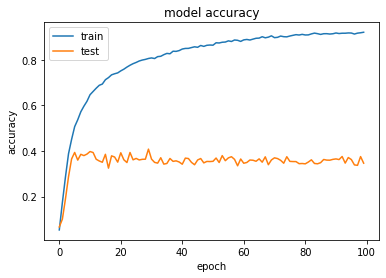

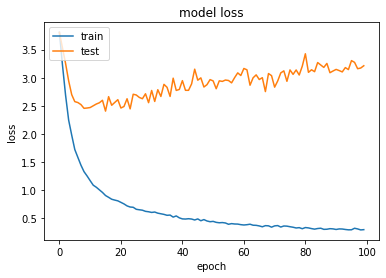

In [32]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

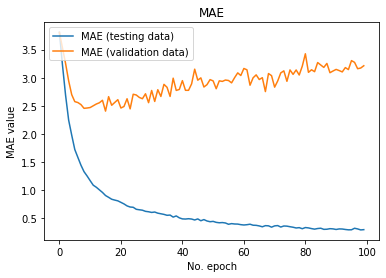

In [33]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

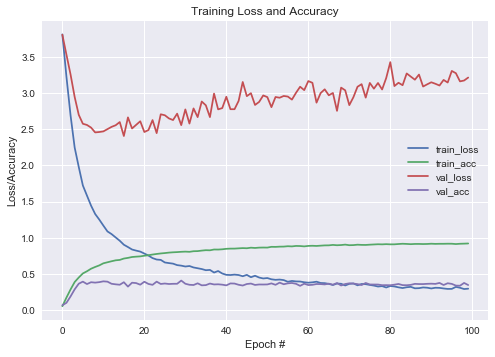

In [34]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochDenseNet121.png')
plt.close()